In [1]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings


from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")
!mkdir output

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Current device is: cuda
mkdir: cannot create directory ‘output’: File exists


### <b><span style='color:#F1A424'>Tokenizers and transformers</span></b>

In [2]:
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import DistilBertModel, DistilBertConfig

from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

env: TOKENIZERS_PARALLELISM=true
tokenizers.__version__: 0.13.3
transformers.__version__: 4.33.0


# <b><span style='color:#F1A424'>|</span> Configuration</b><a class='anchor' id='configuration'></a> [↑](#top) 

***

Central repository for this notebook's hyperparameters.

In [3]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 64
    BATCH_SIZE_VALID = 32
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 2e-5
    ENCODER_LR = 2e-5
    EPOCHS = 5
    EPS = 1e-6
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=1000
    MAX_LEN = 512
    MIN_LR = 1e-6
    MODEL = "distilbert-base-uncased"
    NUM_CYCLES = 0.5
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'cosine' # ['linear', 'cosine']
    SEED = 27
    TRAIN = True
    TRAIN_FOLDS = [0, 1, 2, 3]
    
    WEIGHT_DECAY = 0.01

    
class paths:
    OUTPUT_DIR = "/kaggle/working/output"
    EXTERNAL_DATA = "/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv"
    TRAIN_PROMPTS = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
    TRAIN_ESSAYS = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
    TEST_ESSAYS = "/kaggle/input/llm-detect-ai-generated-text/test_essays.csv"
    

if config.DEBUG:
    config.EPOCHS = 2

# <b><span style='color:#F1A424'>|</span> Utils</b><a class='anchor' id='utils'></a> [↑](#top) 

***

Utility functions used throughout the notebook.

In [4]:
def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items() 
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler
    

def get_score(y_trues, y_preds):
    score = roc_auc_score(y_trues, y_preds)
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

def sep():
    print("-"*100)
    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  
    
LOGGER = get_logger()
seed_everything(seed=config.SEED)

# <b><span style='color:#F1A424'>|</span> Load Data</b><a class='anchor' id='load_data'></a> [↑](#top) 

***

Load data.

In [5]:
train_df = pd.read_csv(paths.TRAIN_ESSAYS, sep=',')
external_df = pd.read_csv(paths.EXTERNAL_DATA, sep=',')
train_prompts = pd.read_csv(paths.TRAIN_PROMPTS, sep=',')
print(f"Train essays dataframe has shape: {train_df.shape}"), sep()
print(f"External essays dataframe has shape: {external_df.shape}"), sep()
print(f"Train prompts dataframe has shape: {train_prompts.shape}"), sep()
display(train_df.head())
display(external_df.head())
display(train_prompts.head())

Train essays dataframe has shape: (1378, 4)
----------------------------------------------------------------------------------------------------
External essays dataframe has shape: (2421, 4)
----------------------------------------------------------------------------------------------------
Train prompts dataframe has shape: (2, 4)
----------------------------------------------------------------------------------------------------


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


,id,text,instructions,source_text
0,6060D28C05B6,Some schools in United States ofter classes fr...,\nTask: Write a persuasive essay on whether or...,\nWhen considering the pros and cons of attend...
1,60623DB5DE7A,"Four-day work week, a remarkable idea to conse...",\nTask: Research the advantages and disadvanta...,\nOne of the primary arguments for implementin...
2,607A39D981DE,Students and their families should consider an...,\nTask: \n\n1. Talk to your parents before tak...,\nBefore making any decisions about getting in...
3,60ACDFA1609E,Agree you will never grow if something beyond ...,\nTask: Write an essay discussing the benefits...,"\nRalph Waldo Emerson once said, ""Go confident..."
4,60AE13D3F07B,I think our character traits are formed by inf...,\nTask: Research and discuss how character tra...,\nHuman character traits are shaped by a wide ...


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


### <b><span style='color:#F1A424'>Add External Data</span></b>

We will use the external data to train our model:
- `source_text` is AI-generated
- `text` is student-written texts from FeedBack prize 3 competition.

In [6]:
external_df1 = external_df[["id", "source_text"]]
external_df1.columns = ["id", "text"]
external_df1['text'] = external_df['text'].str.replace('\n', '')
external_df1["generated"] = 1
external_df2 = external_df[["id", "text"]]
external_df2["generated"] = 0

train_df.drop(columns=["prompt_id"],inplace=True)
train_df = pd.concat([train_df, external_df1, external_df2])
train_df.reset_index(inplace=True, drop=True)
print(f"Train dataframe has shape: {train_df.shape}"), sep()
train_df.head()

Train dataframe has shape: (6220, 3)
----------------------------------------------------------------------------------------------------


,id,text,generated
0,0059830c,Cars. Cars have been around since they became ...,0
1,005db917,Transportation is a large necessity in most co...,0
2,008f63e3,"""America's love affair with it's vehicles seem...",0
3,00940276,How often do you ride in a car? Do you drive a...,0
4,00c39458,Cars are a wonderful thing. They are perhaps o...,0


In [7]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(train_df)

In [8]:
print(train_df.generated.value_counts())
print(test_df.generated.value_counts())

generated
0    2845
1    1820
Name: count, dtype: int64
generated
0    951
1    604
Name: count, dtype: int64


# <b><span style='color:#F1A424'>|</span> Tokenizer</b><a class='anchor' id='tokenizer'></a> [↑](#top) 

***

In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


  0%|          | 0/4665 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1529 > 512). Running this sequence through the model will result in indexing errors
max_len: 512


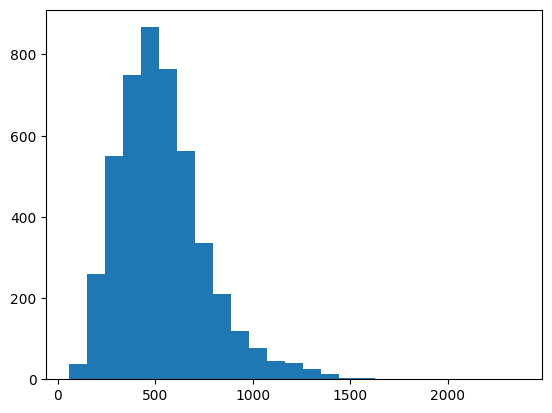

In [10]:
lengths = []
tqdm_loader = tqdm(train_df['text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)

In [11]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch. 
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['generated'].values
        self.tokenizer = tokenizer
        self.text_ids = df['id'].values

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.float) # TODO: check dtypes
        output["ids"] = self.text_ids[item]
        return output

# <b><span style='color:#F1A424'>|</span> Model</b><a class='anchor' id='model'></a> [↑](#top) 

***

In [12]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.dropout = 0.2
        if config_path is None: 
            self.config = DistilBertConfig.from_pretrained(self.cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = DistilBertModel.from_pretrained(self.cfg.MODEL, config=self.config)
        else:
            self.model = DistilBertModel(self.config)
            
        for param in self.model.parameters():
            param.requires_grad = True
            
        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()
          
        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.head = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(16, 1)
        )
        self._init_weights(self.head)
        
    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers 
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # For DistilBert, outputs is a tuple with hidden states as the first item
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.head(feature)
        return output

# <b><span style='color:#F1A424'>|</span> Train and Validation Functions</b><a class='anchor' id='functions'></a> [↑](#top) 

***
    
- [torch.cuda.amp.GradScaler](https://pytorch.org/docs/stable/amp.html#torch.cuda.amp.GradScaler): This class helps writing compute efficient training loops, so we dont get OOM errors. Also, one common error in any large deep learning model is the problem of underflowing gradients (i.e. your gradients are too small to take into account). `float16` tensors often don't take into account extremely small variations. To prevent this we can scale our gradients by some factor so that they aren't flushed to zero. Not to be confused with vanishing gradients, this gradients still might contribute to the learning process however are skipped because of computational limits.
- [torch.autocast](https://pytorch.org/docs/stable/amp.html#torch.autocast)

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))


    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            ids = batch.pop("ids")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))

                
    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict["ids"] = ids
    return losses.avg, prediction_dict

# <b><span style='color:#F1A424'>|</span> Train Loop</b><a class='anchor' id='train_loop'></a> [↑](#top) 

***

In [14]:
test_df

,id,text,generated
5995,EC35456D4E07,"Conserve energy and resources,some businesses ...",0
1425,638D7F913AAB,Do you think the greatest accomplishment in th...,1
3567,EBE636368EBC,People make there own decisions because they d...,1
2560,B4B82E063D04,is setting an good example by your own behavio...,1
5151,C1314085435C,I agree with Ralph waldo Emerson because he sa...,0
...,...,...,...
4164,7ACF284A8B7C,I think that work in groups is more benefit. B...,0
1599,71F12F9F01DE,I agree with this prompt many cases it is impo...,1
3300,DF149975C610,I agree with emerson's statement. I will grow ...,1
3669,F0B44890C961,Dear Sir or Madam:Yes school should control st...,1


In [15]:
def train_loop(train_df, test_df):
    

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_df, tokenizer)
    valid_dataset = CustomDataset(config, test_df, tokenizer)
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, 
                              shuffle=True,
                              pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
    model.to(device)

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=config.ENCODER_LR, 
                                                decoder_lr=config.DECODER_LR,
                                                weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(optimizer_parameters,
                      lr=config.ENCODER_LR,
                      eps=config.EPS,
                      betas=config.BETAS)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-5,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        valid_labels = test_df.generated.values.tolist()
        # ======= SCORING ==========
        score = get_score(valid_labels, sigmoid(predictions))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        

            
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(),
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_best.pth")
            best_model_predictions = predictions

    test_df["preds"] = best_model_predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return test_df

In [16]:
from torch.utils.checkpoint import checkpoint

# <b><span style='color:#F1A424'>|</span> Train</b><a class='anchor' id='train'></a> [↑](#top) 

***

In [17]:
if __name__ == '__main__':
    def get_result(oof_df):
        labels = oof_df["generated"].values
        preds = oof_df["preds"].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if config.TRAIN:
        oof_df = pd.DataFrame()
        _oof_df = train_loop(train_df, test_df)
        oof_df = pd.concat([oof_df, _oof_df])
        get_result(_oof_df)
            
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)

Train:   0%|          | 0/72 [00:00<?, ?train_batch/s]

Epoch: [1][0/72] Elapsed 0m 2s (remain 2m 55s) Loss: 0.7477 Grad: 243199.7656  LR: 0.00000042  
Epoch: [1][20/72] Elapsed 0m 46s (remain 1m 53s) Loss: 0.7060 Grad: 177178.6250  LR: 0.00000668  
Epoch: [1][40/72] Elapsed 1m 30s (remain 1m 8s) Loss: 0.6954 Grad: 156571.1719  LR: 0.00000999  
Epoch: [1][60/72] Elapsed 2m 15s (remain 0m 24s) Loss: 0.6829 Grad: 144546.7969  LR: 0.00000984  
Epoch: [1][71/72] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6799 Grad: 133482.0469  LR: 0.00000968  


Validation:   0%|          | 0/49 [00:00<?, ?valid_batch/s]

EVAL: [0/49] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7317 
EVAL: [20/49] Elapsed 0m 7s (remain 0m 9s) Loss: 0.6618 
EVAL: [40/49] Elapsed 0m 13s (remain 0m 2s) Loss: 0.6527 


Epoch 1 - avg_train_loss: 0.6799  avg_val_loss: 0.6496  time: 176s
Epoch 1 - Score: 0.6709
Epoch 1 - Save Best Score: 0.6709 Model


EVAL: [48/49] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6496 


Train:   0%|          | 0/72 [00:00<?, ?train_batch/s]

Epoch: [2][0/72] Elapsed 0m 2s (remain 2m 39s) Loss: 0.6145 Grad: 128557.2266  LR: 0.00000966  
Epoch: [2][20/72] Elapsed 0m 46s (remain 1m 53s) Loss: 0.6272 Grad: 119459.8750  LR: 0.00000923  
Epoch: [2][40/72] Elapsed 1m 31s (remain 1m 8s) Loss: 0.6368 Grad: 124682.0000  LR: 0.00000864  
Epoch: [2][60/72] Elapsed 2m 15s (remain 0m 24s) Loss: 0.6407 Grad: 115865.5938  LR: 0.00000791  
Epoch: [2][71/72] Elapsed 2m 40s (remain 0m 0s) Loss: 0.6420 Grad: 110593.0234  LR: 0.00000746  


Validation:   0%|          | 0/49 [00:00<?, ?valid_batch/s]

EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7241 
EVAL: [20/49] Elapsed 0m 7s (remain 0m 9s) Loss: 0.6612 
EVAL: [40/49] Elapsed 0m 13s (remain 0m 2s) Loss: 0.6500 


Epoch 2 - avg_train_loss: 0.6420  avg_val_loss: 0.6455  time: 177s
Epoch 2 - Score: 0.6578


EVAL: [48/49] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6455 


Train:   0%|          | 0/72 [00:00<?, ?train_batch/s]

Epoch: [3][0/72] Elapsed 0m 2s (remain 2m 38s) Loss: 0.6113 Grad: 114959.3047  LR: 0.00000742  
Epoch: [3][20/72] Elapsed 0m 46s (remain 1m 53s) Loss: 0.6314 Grad: 116985.4844  LR: 0.00000653  
Epoch: [3][40/72] Elapsed 1m 31s (remain 1m 8s) Loss: 0.6357 Grad: 128626.8359  LR: 0.00000558  
Epoch: [3][60/72] Elapsed 2m 15s (remain 0m 24s) Loss: 0.6355 Grad: 112117.7422  LR: 0.00000461  
Epoch: [3][71/72] Elapsed 2m 39s (remain 0m 0s) Loss: 0.6333 Grad: 98323.5078  LR: 0.00000409  


Validation:   0%|          | 0/49 [00:00<?, ?valid_batch/s]

EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7139 
EVAL: [20/49] Elapsed 0m 7s (remain 0m 9s) Loss: 0.6517 
EVAL: [40/49] Elapsed 0m 13s (remain 0m 2s) Loss: 0.6411 


Epoch 3 - avg_train_loss: 0.6333  avg_val_loss: 0.6372  time: 177s
Epoch 3 - Score: 0.6422


EVAL: [48/49] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6372 


Train:   0%|          | 0/72 [00:00<?, ?train_batch/s]

Epoch: [4][0/72] Elapsed 0m 2s (remain 2m 37s) Loss: 0.6110 Grad: 117373.3984  LR: 0.00000404  
Epoch: [4][20/72] Elapsed 0m 46s (remain 1m 53s) Loss: 0.6310 Grad: 100906.6094  LR: 0.00000311  
Epoch: [4][40/72] Elapsed 1m 31s (remain 1m 8s) Loss: 0.6321 Grad: 110194.1094  LR: 0.00000226  
Epoch: [4][60/72] Elapsed 2m 15s (remain 0m 24s) Loss: 0.6295 Grad: 103351.2734  LR: 0.00000150  
Epoch: [4][71/72] Elapsed 2m 40s (remain 0m 0s) Loss: 0.6287 Grad: 106216.7188  LR: 0.00000114  


Validation:   0%|          | 0/49 [00:00<?, ?valid_batch/s]

EVAL: [0/49] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7092 
EVAL: [20/49] Elapsed 0m 7s (remain 0m 9s) Loss: 0.6498 
EVAL: [40/49] Elapsed 0m 14s (remain 0m 2s) Loss: 0.6397 


Epoch 4 - avg_train_loss: 0.6287  avg_val_loss: 0.6355  time: 177s
Epoch 4 - Score: 0.6326


EVAL: [48/49] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6355 


Train:   0%|          | 0/72 [00:00<?, ?train_batch/s]

Epoch: [5][0/72] Elapsed 0m 2s (remain 2m 38s) Loss: 0.6726 Grad: 103752.4141  LR: 0.00000111  
Epoch: [5][20/72] Elapsed 0m 46s (remain 1m 53s) Loss: 0.6231 Grad: 102149.2500  LR: 0.00000058  
Epoch: [5][40/72] Elapsed 1m 31s (remain 1m 8s) Loss: 0.6310 Grad: 96357.3047  LR: 0.00000021  
Epoch: [5][60/72] Elapsed 2m 15s (remain 0m 24s) Loss: 0.6280 Grad: 101141.3672  LR: 0.00000003  
Epoch: [5][71/72] Elapsed 2m 40s (remain 0m 0s) Loss: 0.6294 Grad: 103610.9844  LR: 0.00000000  


Validation:   0%|          | 0/49 [00:00<?, ?valid_batch/s]

EVAL: [0/49] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7162 
EVAL: [20/49] Elapsed 0m 7s (remain 0m 9s) Loss: 0.6568 
EVAL: [40/49] Elapsed 0m 13s (remain 0m 2s) Loss: 0.6462 


Epoch 5 - avg_train_loss: 0.6294  avg_val_loss: 0.6423  time: 177s
Epoch 5 - Score: 0.6322


EVAL: [48/49] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6423 


Score: 0.6709
========== CV ==========
Score: 0.6709


In [18]:
oof_df["preds"] = oof_df["preds"].apply(lambda x: sigmoid(x))
oof_df

,id,text,generated,preds
0,EC35456D4E07,"Conserve energy and resources,some businesses ...",0,0.635946
1,638D7F913AAB,Do you think the greatest accomplishment in th...,1,0.602844
2,EBE636368EBC,People make there own decisions because they d...,1,0.651876
3,B4B82E063D04,is setting an good example by your own behavio...,1,0.587057
4,C1314085435C,I agree with Ralph waldo Emerson because he sa...,0,0.686414
...,...,...,...,...
1550,7ACF284A8B7C,I think that work in groups is more benefit. B...,0,0.678539
1551,71F12F9F01DE,I agree with this prompt many cases it is impo...,1,0.620143
1552,DF149975C610,I agree with emerson's statement. I will grow ...,1,0.656847
1553,F0B44890C961,Dear Sir or Madam:Yes school should control st...,1,0.635581


### <b><span style='color:#F1A424'>Confusion Matrix</span></b>


In [19]:
torch.save(model.state_dict(), '/kaggle/working/output/custom_model_state_dict.pt')
torch.save(model.config, '/kaggle/working/output/model_config.pth')


NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix

def binarize(x, threshold):
    if x > threshold:
        x = 1
    else:
        x = 0
    return x

# Assuming df is your pandas DataFrame
oof_df["binary"] = oof_df["preds"].apply(lambda x: binarize(x, 0.5))
true_labels = oof_df["generated"].values
predicted_labels = oof_df["binary"].values

# Get the unique classes from both true and predicted labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [20]:
!zip -r output.zip /kaggle/working/output

  adding: kaggle/working/output/ (stored 0%)
  adding: kaggle/working/output/tokenizer/ (stored 0%)
  adding: kaggle/working/output/tokenizer/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/output/tokenizer/tokenizer_config.json (deflated 43%)
  adding: kaggle/working/output/tokenizer/vocab.txt (deflated 53%)
  adding: kaggle/working/output/tokenizer/tokenizer.json (deflated 71%)
  adding: kaggle/working/output/distilbert-base-uncased_best.pth (deflated 8%)
  adding: kaggle/working/output/config.pth (deflated 48%)
  adding: kaggle/working/output/oof_df.csv (deflated 68%)
